In [3]:
import torch
import torch.fft
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import matplotlib.pyplot as plt
import numpy as np
import random 
from torchvision.datasets import ImageFolder
import re
from torch.utils.data import Dataset, DataLoader
import h5py

import fastmri 
from fastmri.fftc import fft2c_new, ifft2c_new
from fastmri.math import complex_abs

from torch.distributions import multivariate_normal

#os.chdir('/content/drive/MyDrive/MRI/MRI_Project')
#import deepbrainnew
#from deepbrainnew import Extractor
import nibabel as nib
import skimage
import pandas as pd
from h5_dataloader import MRIDataset_h5
from loss import mse,nmse,psnr,ssim

import math
import time 

#realcov = torch.load('./results_gpr_hyper_new/covmat_6822/realcov_L1_11_L2_11.pt')
#imagcov = torch.load('./results_gpr_hyper_new/covmat_6822/imagcov_L1_11_L2_11.pt')

#realcov = torch.load('./results_gpr_hyper_new/covmat_431/realcov_L1_6.pt')
#imagcov = torch.load('./results_gpr_hyper_new/covmat_431/imagcov_L1_6.pt')

realcov = torch.load('./brain_stats/real_cov_6822_nor.pt')
imagcov = torch.load('./brain_stats/imag_cov_6822_nor.pt')

#realcov = torch.load('./results_gpr_hyper_new/covmat_6822/realcov_L1_11_L2_11.pt')
#imagcov = torch.load('./results_gpr_hyper_new/covmat_6822/imagcov_L1_11_L2_11.pt')

realmean = torch.load('./brain_stats/train_realmean_6822.pt').reshape(160,160)
imagmean = torch.load('./brain_stats/train_imagmean_6822.pt').reshape(160,160)

magmean = torch.load('./brain_stats/train_magmean_6822.pt').reshape(160,160)

realmean = (realmean/magmean)
imagmean = (imagmean/magmean)

realvar= torch.diagonal(realcov)
imagvar= torch.diagonal(imagcov)





dataset = MRIDataset_h5(in_file = '../IXI_data/IXI_T1_h5/t1_test_256.h5',mode = 'real_imag')
print(len(dataset))
device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {} 

imgsz = 256
w = 48

bs = 1
train_loader = DataLoader(dataset, batch_size=bs, drop_last=False, shuffle= False,**kwargs)



1000


In [10]:
######### Reconstruction Function #########

def zerofill_samp(img1_k,ind):
  img_r = fastmri.complex_abs(ifft2c_new(img1_k)).view(-1,1)
  img_r = img_r.reshape(imgsz,imgsz)
  pixnum = len(ind)
  img1_k_ = img1_k[w:imgsz-w,w:imgsz-w,:]
  picked_r = img1_k_[:,:,0].reshape(-1,1)
  picked_i = img1_k_[:,:,1].reshape(-1,1)

  for i in range((imgsz-2*w)**2):
    if i not in ind:
      picked_r[i,0] = 0 
      picked_i[i,0] = 0 

  picked_r = picked_r.reshape(imgsz-2*w,imgsz-2*w)
  picked_i = picked_i.reshape(imgsz-2*w,imgsz-2*w)

  picked_k = torch.stack([picked_r,picked_i],dim = 2) 

  whole_k = torch.zeros(imgsz,imgsz,2)
  whole_k[w:imgsz-w,w:imgsz-w,:] = picked_k
  rcon = fastmri.complex_abs(ifft2c_new(whole_k))
  
  nmse_ =  nmse(img_r.numpy(),rcon.numpy())
  ssim_ =  ssim(img_r.numpy(),rcon.numpy())
  psnr_ = psnr(img_r.numpy(),rcon.numpy())
  

  return rcon,nmse_,ssim_,psnr_


def zerofill_samp_imgsz(img1_k,ind):
  pixnum = len(ind)

  picked_r = img1_k[:,:,0].view(-1,1)
  picked_i = img1_k[:,:,1].view(-1,1)

  for i in range(imgsz*imgsz):
    if i not in ind:
      picked_r[i,0] = 0 
      picked_i[i,0] = 0 

  picked_r = picked_r.reshape(imgsz,imgsz)
  picked_i = picked_i.reshape(imgsz,imgsz)

  rcon = fastmri.complex_abs(ifft2c_new(torch.stack([picked_r,picked_i],dim=2)))
  
  nmse_ =  nmse(img1_r.numpy(),rcon.numpy())
  ssim_ =  ssim(img1_r.numpy(),rcon.numpy())
  psnr_ = psnr(img1_r.numpy(),rcon.numpy())
  return rcon,nmse_,ssim_,psnr_



def bayesian_stat_r(img_k1,ind,sig,ind_previous = None):
  #img_k1 size: cropped sized (imgsz-2*w, imgsz-2*w)

  pixnum = len(ind)

  realcovmat = realcov[ind,:][:,ind] + sig*torch.eye(pixnum)
  imagcovmat = imagcov[ind,:][:,ind] + sig*torch.eye(pixnum)

  realcovvec = realcov[:,ind]
  imagcovvec = imagcov[:,ind]  

  for i in range(len(ind)):
    realcovmat[i,i] = realvar[ind[i]] + sig
    imagcovmat[i,i] = imagvar[ind[i]] + sig
    realcovvec[ind[i],i] = realvar[ind[i]]
    imagcovvec[ind[i],i] = imagvar[ind[i]]

  rmean = torch.matmul(realcovvec,torch.matmul(torch.inverse(realcovmat),(img_k1[:,:,0]-realmean).view(-1,1)[ind])) + realmean.view(-1,1)
  imean = torch.matmul(imagcovvec,torch.matmul(torch.inverse(imagcovmat),(img_k1[:,:,1]-imagmean).view(-1,1)[ind])) + imagmean.view(-1,1)


  rvar = realvar - torch.sum(torch.matmul(realcov[:,ind],torch.inverse(realcovmat))*realcov[:,ind],1) + sig 
  ivar = imagvar - torch.sum(torch.matmul(imagcov[:,ind],torch.inverse(imagcovmat))*imagcov[:,ind],1) + sig

  if ind_previous != None: 
    ind = torch.cat([ind_previous,ind])

  rmean[ind] = (img_k1[:,:,0].reshape((imgsz-2*w)**2,1))[ind]
  imean[ind] = (img_k1[:,:,1].reshape((imgsz-2*w)**2,1))[ind]

  rmean = rmean.reshape(imgsz-2*w,imgsz-2*w)
  imean = imean.reshape(imgsz-2*w,imgsz-2*w)

  #set all sampled (previous + current) position variance as sigma
 # rvar[ind] = sig
 # ivar[ind] = sig


  return rmean,imean,rvar,ivar


def bayesian_stat_r_nor(img_k1,ind,sig,realcov_,imagcov_,ind_previous = None):
  #img_k1 size: cropped sized (imgsz-2*w, imgsz-2*w)

  pixnum = len(ind)

  realcovmat = realcov_[ind,:][:,ind] + sig*torch.eye(pixnum)
  imagcovmat = imagcov_[ind,:][:,ind] + sig*torch.eye(pixnum)

  realcovvec = realcov_[:,ind]
  imagcovvec = imagcov_[:,ind]  

  for i in range(len(ind)):
    realcovmat[i,i] = realvar[ind[i]] + sig
    imagcovmat[i,i] = imagvar[ind[i]] + sig
    realcovvec[ind[i],i] = realvar[ind[i]]
    imagcovvec[ind[i],i] = imagvar[ind[i]]

  rmean = torch.matmul(realcovvec,torch.matmul(torch.inverse(realcovmat),(img_k1[:,:,0]/magmean-realmean).view(-1,1)[ind])) + realmean.view(-1,1)
  imean = torch.matmul(imagcovvec,torch.matmul(torch.inverse(imagcovmat),(img_k1[:,:,1]/magmean-imagmean).view(-1,1)[ind])) + imagmean.view(-1,1)
  
  #mag_nor = torch.sqrt(rmean**2+imean**2)
  #rmean = rmean/mag_nor 
  #imean = imean/mag_nor 
  #rmean[mag_nor == 0] = 0 
  #imean[mag_nor == 0] = 0 
#for the sampled areas 
  rmean[ind] = ((img_k1[:,:,0]/magmean).reshape((imgsz-2*w)**2,1))[ind]
  imean[ind] = ((img_k1[:,:,1]/magmean).reshape((imgsz-2*w)**2,1))[ind]

  rvar = realvar - torch.sum(torch.matmul(realcov[:,ind],torch.inverse(realcovmat))*realcov[:,ind],1) + sig 
  ivar = imagvar - torch.sum(torch.matmul(imagcov[:,ind],torch.inverse(imagcovmat))*imagcov[:,ind],1) + sig

  if ind_previous != None: 
    ind = torch.cat([ind_previous,ind])

 
  kmean = torch.stack([(rmean).reshape(imgsz-2*w,imgsz-2*w)*magmean,\
                         (imean).reshape(imgsz-2*w,imgsz-2*w)*magmean],dim=2)   
  

  rmean = rmean.reshape(imgsz-2*w,imgsz-2*w)
  imean = imean.reshape(imgsz-2*w,imgsz-2*w)

  #set all sampled (previous + current) position variance as sigma
 # rvar[ind] = sig
 # ivar[ind] = sig


  return rmean,imean,kmean,rvar,ivar

  
def bayesian_mean_samp(img1_k,realmat,imagmat,ind,lamb):
  pixnum = len(ind)

  #ind = torch.randint(0,imgsz*imgsz,(pixnum,))
  img1_r = fastmri.complex_abs(ifft2c_new(img1_k)).view(-1,1)
  img1_r = img1_r.reshape(imgsz,imgsz)
  img1_k_ = (img1_k[w:imgsz-w,:,:])[:,w:imgsz-w,:]
  
  realcovmat = realmat[ind,:][:,ind] + lamb*torch.eye(pixnum)
  imagcovmat = imagmat[ind,:][:,ind] + lamb*torch.eye(pixnum)

  realcovvec = realmat[:,ind]
  imagcovvec = imagmat[:,ind]  
  rmean = torch.matmul(realcovvec,torch.matmul(torch.inverse(realcovmat),(img1_k_[:,:,0]-realmean).view(-1,1)[ind])) + realmean.reshape(-1,1)
  imean = torch.matmul(imagcovvec,torch.matmul(torch.inverse(imagcovmat),(img1_k_[:,:,1]-imagmean).view(-1,1)[ind])) + imagmean.reshape(-1,1)

  rmean[ind] = img1_k_[:,:,0].reshape(-1,1)[ind]
  imean[ind] = img1_k_[:,:,1].reshape(-1,1)[ind]

  rmean = rmean.reshape(imgsz-2*w,imgsz-2*w)
  imean = imean.reshape(imgsz-2*w,imgsz-2*w)

  kmean = torch.stack([rmean.reshape(imgsz-2*w,imgsz-2*w),imean.reshape(imgsz-2*w,imgsz-2*w)],dim=2)
  kmean_whole = torch.zeros(imgsz,imgsz,2)
  kmean_whole[w:imgsz-w,w-1:imgsz-w,:] = kmean
  bayesian_mean = fastmri.complex_abs(ifft2c_new(kmean_whole))
  
  nmse_ =  nmse(img1_r.numpy(),bayesian_mean.numpy())
  ssim_ =  ssim(img1_r.numpy(),bayesian_mean.numpy())
  psnr_ = psnr(img1_r.numpy(),bayesian_mean.numpy())
  
  return bayesian_mean,nmse_,ssim_,psnr_

def bayesian_mean_samp_new(img1_k,ind,lamb):
  pixnum = len(ind)

  #ind = torch.randint(0,imgsz*imgsz,(pixnum,))
  img1_r = fastmri.complex_abs(ifft2c_new(img1_k)).view(-1,1)
  img1_r = img1_r.reshape(imgsz,imgsz)
  img1_k_ = (img1_k[w:imgsz-w,:,:])[:,w:imgsz-w,:]
  
  realcovmat = realcov[ind,:][:,ind] 
  imagcovmat = imagcov[ind,:][:,ind] 

  for i in range(len(ind)): 
    realcovmat[i,i] = realvar[ind[i]] + lamb*torch.abs(realmean.view(-1)[ind[i]])
    imagcovmat[i,i] = imagvar[ind[i]] +  lamb*torch.abs(imagmean.view(-1)[ind[i]])

  realcovvec = realcov[:,ind]
  imagcovvec = imagcov[:,ind]  
  rmean = torch.matmul(realcovvec,torch.matmul(torch.inverse(realcovmat),(img1_k_[:,:,0]-realmean).view(-1,1)[ind])) + realmean.reshape(-1,1)
  imean = torch.matmul(imagcovvec,torch.matmul(torch.inverse(imagcovmat),(img1_k_[:,:,1]-imagmean).view(-1,1)[ind])) + imagmean.reshape(-1,1)

  rmean[ind] = img1_k_[:,:,0].reshape(-1,1)[ind]
  imean[ind] = img1_k_[:,:,1].reshape(-1,1)[ind]

  rmean = rmean.reshape(imgsz-2*w,imgsz-2*w)
  imean = imean.reshape(imgsz-2*w,imgsz-2*w)

  kmean = torch.stack([rmean.reshape(imgsz-2*w,imgsz-2*w),imean.reshape(imgsz-2*w,imgsz-2*w)],dim=2)
  kmean_whole = torch.zeros(imgsz,imgsz,2)
  kmean_whole[w:imgsz-w,w:imgsz-w,:] = kmean
  bayesian_mean = fastmri.complex_abs(ifft2c_new(kmean_whole))
  
  nmse_ =  nmse(img1_r.numpy(),bayesian_mean.numpy())
  ssim_ =  ssim(img1_r.numpy(),bayesian_mean.numpy())
  psnr_ = psnr(img1_r.numpy(),bayesian_mean.numpy())
  
  return bayesian_mean,nmse_,ssim_,psnr_

def bayesian_mean_samp_nor(img1_k,ind,lamb):
  pixnum = len(ind)

  #ind = torch.randint(0,imgsz*imgsz,(pixnum,))
  img1_r = fastmri.complex_abs(ifft2c_new(img1_k)).view(-1,1)
  img1_r = img1_r.reshape(imgsz,imgsz)
  img1_k_ = (img1_k[w:imgsz-w,:,:])[:,w:imgsz-w,:]
  
  realcovmat = realcov[ind,:][:,ind] + lamb*torch.eye(pixnum)
  imagcovmat = imagcov[ind,:][:,ind] + lamb*torch.eye(pixnum)

  realcovvec = realcov[:,ind]
  imagcovvec = imagcov[:,ind]  
  rmean = torch.matmul(realcovvec,torch.matmul(torch.inverse(realcovmat),(img1_k_[:,:,0]/magmean-realmean).view(-1,1)[ind])) + realmean.reshape(-1,1)
  imean = torch.matmul(imagcovvec,torch.matmul(torch.inverse(imagcovmat),(img1_k_[:,:,1]/magmean-imagmean).view(-1,1)[ind])) + imagmean.reshape(-1,1)


  rmean[ind] = ((img1_k_[:,:,0]/magmean).reshape((imgsz-2*w)**2,1))[ind]
  imean[ind] = ((img1_k_[:,:,1]/magmean).reshape((imgsz-2*w)**2,1))[ind]
 
  kmean = torch.stack([(rmean).reshape(imgsz-2*w,imgsz-2*w)*magmean,\
                         (imean).reshape(imgsz-2*w,imgsz-2*w)*magmean],dim=2)   
  
  kmean_whole = torch.zeros(imgsz,imgsz,2)
  kmean_whole[w:imgsz-w,w:imgsz-w,:] = kmean
  bayesian_mean = fastmri.complex_abs(ifft2c_new(kmean_whole))
  
  nmse_ =  nmse(img1_r.numpy(),bayesian_mean.numpy())
  ssim_ =  ssim(img1_r.numpy(),bayesian_mean.numpy())
  psnr_ = psnr(img1_r.numpy(),bayesian_mean.numpy())
  
  return bayesian_mean,nmse_,ssim_,psnr_


######### Geometric Function #########
def mask_of_r(imgsz,r):
  mask = torch.zeros(imgsz,imgsz)

  for i in range(imgsz):
    for j in range(imgsz): 
      i_ = i - (imgsz-1)/2
      j_ = j - (imgsz-1)/2
    
      if (i_**2+j_**2)**0.5 >= r and (i_**2+j_**2)**0.5 < r+1: 
  #  if np.round((i_**2+j_**2)**0.5) == r:
        mask[i,j] = 1 

  return mask 

def mask_in_r(imgsz,r):
  mask = torch.zeros(imgsz,imgsz)

  for i in range(imgsz):
    for j in range(imgsz): 
      i_ = i - (imgsz-1)/2
      j_ = j - (imgsz-1)/2
    
      if (i_**2+j_**2)**0.5 <= r:  
        mask[i,j] = 1 
  return mask 

def mask_of_phi(imgsz,r_low,r_high,phi_low,phi_up):
  mask = torch.zeros(imgsz,imgsz)
  for i in range(imgsz):
    for j in range(imgsz): 
      i_ = torch.tensor([(imgsz-1-i) - (imgsz - 1)/2])
      j_ = torch.tensor([j - (imgsz - 1)/2])
      if torch.sqrt(i_**2+j_**2) > r_low and torch.sqrt(i_**2+j_**2) <= r_high: 
        if phi_low <= (torch.atan(i_/j_)) and (torch.atan(i_/j_)) < phi_up: 
          mask[i,j] = 1 

  return mask 

def mask_of_r_order(imgsz,rlist):
  mask = torch.zeros(imgsz,imgsz).view(-1)
  ratio = torch.zeros(len(rlist))
  n = 0
  for i in rlist: 
    mask[r_dic[int(i)]] = 1
    ratio[n] = torch.sum(mask == 1)/256**2
    n += 1

  mask = mask.reshape(imgsz,imgsz)

  return mask, ratio 


def mask_of_horline_order(imgsz,linelist): 
  mask = torch.zeros(imgsz-2*w,imgsz-2*w)
  mask[linelist,:] = 1 
  return mask 


##make r index dictionary
r_dic = {}

rlist = np.linspace(0,int((imgsz-2*w)/2),int((imgsz-2*w)/2)+1,dtype=int)
indlist = np.linspace(0,(imgsz-2*w)**2-1,(imgsz-2*w)**2,dtype=int)
for i in rlist: 
  mask = mask_of_r(imgsz-2*w,i)
  r_dic[i] = indlist[mask.view(-1) == 1]


def magerror_rrank(imgsz,w,errormag):
  rlist = np.linspace(0,int((imgsz-2*w)/2),int((imgsz-2*w)/2+1),dtype=int)
  errorlist = torch.zeros(int((imgsz-2*w)/2)+1)
  start = time.time()

  for i in rlist: 
    errorlist[i] = torch.mean(errormag.view(-1)[r_dic[i]]) 
  
  end = time.time()
  return errorlist

def mask_larger(imgsz,w,mask): 
  mask_ = torch.zeros(256,256)
  mask_[w:imgsz-w,w:imgsz-w] = mask
  return mask_


def mask_r_phis(r,phi_list): 
  mask = torch.zeros(imgsz-2*w,imgsz-2*w)
  ind_list = r_dic[r]
  
  i,j = ind_to_xy(ind_list)
  phi = xy_to_phi(i,j)
  for phi_i in phi_list: 
    del_phi = abs(phi - phi_i) 
    ind_phi = torch.argmin(del_phi)
    mask[i[ind_phi],j[ind_phi]] = 1

  return mask

def ind_to_ij(ind): 
  return ind//(imgsz-2*w),ind%(imgsz-2*w)

def ind_to_xy(ind): 
  i = (ind//(imgsz-2*w))
  j = (ind%(imgsz-2*w))
  y = (imgsz-2*w-1-i) - (imgsz-2*w - 1)/2
  x = j - (imgsz-2*w - 1)/2
  return x,y

def ij_to_phi(i,j): 
  i_ = (imgsz-2*w-1-i) - (imgsz-2*w - 1)/2
  j_ = j - (imgsz-2*w - 1)/2
  #phi: size(1,#pixels)
  return torch.atan2(i_,j_)

def xy_to_ind(x,y): 
  i = (imgsz-2*w-1) - (imgsz-2*w - 1)/2 - y 
  j = x + (imgsz-2*w - 1)/2
  ind = i*(imgsz-2*w) + j
  return ind



def GPR_cir_nor(img_k,round,thre,mode = None):
  #img_k: original size k-space image 
  img_r = fastmri.complex_abs(ifft2c_new(img_k)).view(-1,1)
  img_r = img_r.reshape(imgsz,imgsz)
  #crop the k-space image
  img_k_ = (img_k[w:imgsz-w,:,:])[:,w:imgsz-w,:]

  error_whole = torch.zeros(round,imgsz-2*w,imgsz-2*w) 
  errormag_list = torch.zeros(round,(imgsz - 2*w)//2+1)
  results_list = torch.zeros(round, 4)
  #img_list = torch.zeros(round,imgsz,imgsz)

  r_list = []

  realcov_ = torch.clone(realcov)
  imagcov_ = torch.clone(imagcov)
  realmean_ = torch.clone(realmean)
  imagmean_ = torch.clone(imagmean)

  realvar_ = torch.clone(realvar)
  imagvar_ = torch.clone(imagvar) 

#  realcov_[abs(realcov) < thre] = 0
#  imagcov_[abs(imagcov) < thre] = 0

  #ind_list = [] 


  if mode == 'pix_var': 
    realvar_all = torch.zeros((imgsz-2*w)**2,round)
    imagvar_all = torch.zeros((imgsz-2*w)**2,round)
    magerr_all = torch.zeros((imgsz-2*w)**2,round)
  else: 
    realvar_all = 0
    imagvar_all = 0 
    magerr_all = 0 


  for i in range(round): 

    mag = torch.sqrt(realmean_**2 + imagmean_**2)
    if mode == 'pix_var': 
      realvar_all[:,i] = realvar_
      imagvar_all[:,i] = imagvar_

    realvar_[realvar_ < 0] = sig
    imagvar_[imagvar_ < 0] = sig
      
    errorreal = realvar_**0.5
    errorimag = imagvar_**0.5
        
    errormag = torch.sqrt((realmean_.view(-1))**2*errorreal**2+(imagmean_.view(-1))**2*errorimag**2)/(mag/magmean).view(-1)
    #errormag = torch.sqrt((realmean_.view(-1))**2*errorreal**2+(imagmean_.view(-1))**2*errorimag**2)/(mag).view(-1)
    errormag[(mag*magmean).view(-1) == 0] = 0
    
    error_whole[i,:,:] = errormag.reshape(160,160)
    if mode == 'pix_var': 
      magerr_all[:,i] = errormag   

  #calculate the mean magnitude error and find the maximum position to sample 

    errormagmean = magerror_rrank(imgsz,w,errormag)
    errormag_list[i,:] = errormagmean

    sorted_error, ind_r = torch.sort(errormagmean, descending = True)
    for ind in ind_r: 
      if ind not in r_list: 
        r_ind = ind 
        break 
    
    #r_ind = torch.argmax(errormagmean)
 
    ind0 = torch.from_numpy(r_dic[r_ind.item()])

    r_list.append(r_ind)
    print('round',i,r_ind.item(),'k:',(mask_of_r_order(160,r_list)[1])[-1])    
    

    #update distribution 
    if i == 0: 
      
      realmean_,imagmean_,kmean,realvar_,imagvar_ = bayesian_stat_r_nor(img_k_,ind0,sig,realcov_,imagcov_,ind_previous = None)
      ind_list = ind0

    else: 
      ind_list = torch.cat([ind_list,ind0])
      if i != round - 1: 
          realmean_,imagmean_,kmean,realvar_,imagvar_  = bayesian_stat_r_nor(img_k_,ind_list,sig,realcov_,imagcov_,ind_previous = None)
 #kmean_:already denormolized, real&imagmean: normalized and divided by sqrt(real^2+imag^2)
      

    kmean_whole = torch.zeros(imgsz,imgsz,2)
    kmean_whole[w:imgsz-w,w:imgsz-w,:] = kmean
#    bayesian_mean = fastmri.complex_abs(ifft2c_new(kmean_whole))

#    nmse_ =  nmse(img_r.numpy(),bayesian_mean.numpy())
#    ssim_ =  ssim(img_r.numpy(),bayesian_mean.numpy())
#    psnr_ = psnr(img_r.numpy(),bayesian_mean.numpy())

#    results_list[i,:] = torch.tensor([len(ind_list)/256**2,nmse_,ssim_,psnr_])

#    print('round:',i,r_ind,'nmse:',results_list[i,0],results_list[i,1])

  return r_list, errormag_list, error_whole



## Find the Optimal Path ##

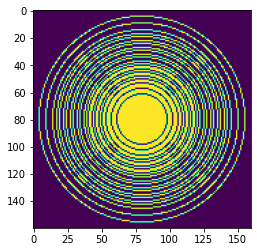

In [19]:
plt.imshow(mask_of_r_order(160,r_list_whole[j-ini-1,:][:45])[0])

In [5]:
r_list_whole = torch.from_numpy(np.load( \
                './results_gpr_noniter_new/r_list_whole_L1_10_6822_0-34.npy'))
errormag_whole =  torch.from_numpy(np.load( \
                './results_gpr_noniter_new/r_errormag_whole_nor_L1_10_6822_0-34.npy'))


In [15]:
#Find the Optimal Path 
sig = 1e-3

#optimal path finding starts at ini 
ind0 = 431
ini = ind0 + 0
rep = ind0 + 1
round = 15

bs = 1
train_loader = DataLoader(dataset, batch_size=bs, drop_last=False, shuffle= False,**kwargs)

r_list_whole = torch.zeros(round)
errormag_whole = torch.zeros(round,(imgsz - 2*w)//2+1)
error_whole = torch.zeros(round, 160,160)

for j,image in enumerate(train_loader): 
    if j >= ini: 
        img_k0 = image[0,:,:,:]
    
        r_list, errormag_list,error_whole = GPR_cir_nor(img_k0,round,sig,mode = None)
       # r_list_whole[:] = torch.tensor(r_list) 
       # errormag_whole[:,:] = errormag_list
       # error_whole[j-ini,:,:,:] = error_whole
        
        np.save('./results_gpr_noniter_new/r_list_whole_nor_6822_example.npy',r_list)
        np.save('./results_gpr_noniter_new/r_errormag_whole_nor_6822_example.npy',errormag_list)
        np.save('./results_gpr_noniter_new/r_error_whole_nor_6822_example.npy',error_whole)
#      np.save('./results_gpr_noniter/r_results_whole_nor_delta.npy',results_whole)
        break
    if (j+1) == rep:
        break 




round 0 0 k: tensor(6.1035e-05)
round 1 1 k: tensor(0.0002)
round 2 3 k: tensor(0.0005)
round 3 8 k: tensor(0.0012)
round 4 5 k: tensor(0.0017)
round 5 13 k: tensor(0.0029)
round 6 10 k: tensor(0.0039)
round 7 18 k: tensor(0.0055)
round 8 2 k: tensor(0.0058)
round 9 15 k: tensor(0.0073)
round 10 23 k: tensor(0.0094)
round 11 6 k: tensor(0.0101)
round 12 20 k: tensor(0.0121)
round 13 28 k: tensor(0.0147)
round 14 11 k: tensor(0.0157)


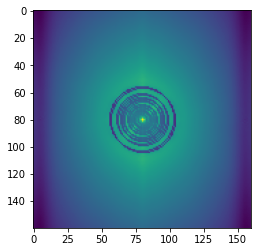

In [21]:
plt.imshow(torch.log(error_whole[12,:,:]))

### Without Envelope Function ###

(50,)
[ 0.  1.  3.  8.  5. 13. 10. 18.  2. 15. 23.  6. 20. 28. 11. 25. 33. 38.
 30.  7. 16.  4. 44. 35. 12. 49.  9. 21. 41. 54. 26. 14. 59. 46. 17. 51.
 31. 64. 19. 36. 56. 69. 22. 40. 24. 61. 27. 74. 43. 29.]
[0, 11, 16, 20, 24, 28, 31, 33, 36, 39, 41, 44, 46]
[0, 16, 24, 31, 36, 41, 46]
7
tensor(6.1035e-05)
tensor(0.0211)
tensor(0.0395)
tensor(0.0600)
tensor(0.0790)
tensor(0.1024)
tensor(0.1201)
tensor(0.1276)


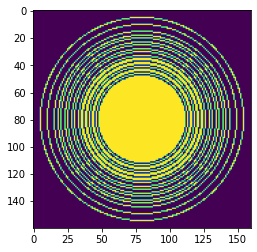

In [9]:
r_list_whole_ = np.load('./results_gpr_noniter_new/rnor_pattern_6822_opt.npy')
print(r_list_whole_.shape)

mask = mask_of_r_order(imgsz-2*w,r_list_whole_)
ratio = 0.01


r2 = r_list_whole_[:]
r_list = []
for i in range(13):
  del_r = torch.abs(mask[1] - ratio*i)
  r_list.append(torch.argmin(del_r).item())

r_list_new = []  
for i in range(len(r_list)): 
    if i%2 == 0: 
        r_list_new.append(r_list[i])

print(r_list_whole_)
print(r_list)
print(r_list_new)
print(len(r_list_new))


plt.imshow(mask[0])

r_list_new_2 = np.array([0, 16, 24, 31, 36, 41, 46, 47])
for i in r_list_new_2:
    mask = mask_of_r_order(imgsz-2*w,r_list_whole_[:i+1])
    print(mask[1][-1])

### For L1 Function ###

(50,)
[ 0.  1.  3.  8.  5. 12.  2.  7. 10. 16.  4. 14. 20.  6.  9. 18. 24. 13.
 22. 17. 28. 11. 26. 32. 21. 15. 30. 37. 25. 34. 42. 19. 29. 36. 47. 40.
 23. 33. 52. 44. 39. 27. 46. 57. 50. 43. 31. 54. 62. 38.]
[0, 12, 18, 23, 27, 30, 33, 36, 39, 41, 43, 46, 48]
[0, 18, 27, 33, 39, 43, 48]
7
tensor(6.1035e-05)
tensor(0.0198)
tensor(0.0409)
tensor(0.0591)
tensor(0.0820)
tensor(0.0981)
tensor(0.1215)
tensor(0.1252)


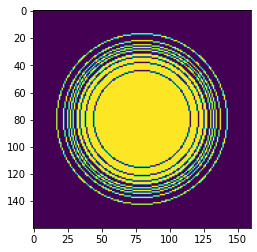

In [10]:
r_list_whole_ = np.load('./results_gpr_noniter_new/rnor_pattern_L1_12_6822_opt.npy')
print(r_list_whole_.shape)

mask = mask_of_r_order(imgsz-2*w,r_list_whole_)
ratio = 0.01


r2 = r_list_whole_[:]
r_list = []
for i in range(13):
  del_r = torch.abs(mask[1] - ratio*i)
  r_list.append(torch.argmin(del_r).item())

r_list_new = []  
for i in range(len(r_list)): 
    if i%2 == 0: 
        r_list_new.append(r_list[i])

print(r_list_whole_)
print(r_list)
print(r_list_new)
print(len(r_list_new))


plt.imshow(mask[0])

r_list_new_2 = np.array([0, 18, 27, 33, 39, 43, 48,49])
for i in r_list_new_2:
    mask = mask_of_r_order(imgsz-2*w,r_list_whole_[:i+1])
    print(mask[1][-1])

## For L1 = L2 Function ##

(46,)
[ 0.  1.  3.  8.  5. 13. 10. 17.  2. 21.  6. 15. 25. 19. 30. 11. 23. 35.
 27. 40.  7. 32. 45.  4. 37. 12. 50. 42.  9. 55. 14. 47. 60. 28. 52. 65.
 33. 16. 57. 70. 24. 62. 38. 20. 75. 43.]
[0, 11, 16, 19, 23, 26, 29, 32, 34, 37, 39, 41, 43]
[0, 16, 23, 29, 34, 39, 43]
7
tensor(6.1035e-05)
tensor(0.0206)
tensor(0.0393)
tensor(0.0598)
tensor(0.0790)
tensor(0.1030)
tensor(0.1247)


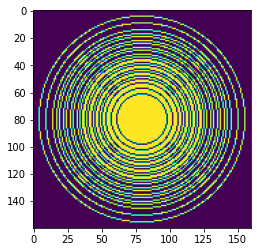

In [28]:
r_list_whole_ = np.load('./results_gpr_noniter_new/rnor_pattern_L1L2_11_6822_opt.npy')
print(r_list_whole_.shape)

mask = mask_of_r_order(imgsz-2*w,r_list_whole_)
ratio = 0.01


r2 = r_list_whole_[:]
r_list = []
for i in range(13):
  del_r = torch.abs(mask[1] - ratio*i)
  r_list.append(torch.argmin(del_r).item())

r_list_new = []  
for i in range(len(r_list)): 
    if i%2 == 0: 
        r_list_new.append(r_list[i])

print(r_list_whole_)
print(r_list)
print(r_list_new)
print(len(r_list_new))


plt.imshow(mask[0])

r_list_new_2 = np.array([0, 16, 23, 29, 34, 39, 44])
for i in r_list_new_2:
    mask = mask_of_r_order(imgsz-2*w,r_list_whole_[:i+1])
    print(mask[1][-1])

In [31]:
a = torch.from_numpy(np.load('./results_gpr_final_new/r_nor_L1L2_11_6822_0-500.npy'))
a[:81]

tensor([[[6.1035e-05, 2.1636e-01, 4.8031e-01, 2.0925e+01],
         [2.0569e-02, 1.8266e-02, 8.8478e-01, 3.1660e+01],
         [3.9307e-02, 9.0431e-03, 9.4437e-01, 3.4713e+01],
         ...,
         [7.9041e-02, 4.0912e-03, 9.7180e-01, 3.8158e+01],
         [1.0303e-01, 2.6547e-03, 9.7466e-01, 4.0036e+01],
         [1.2469e-01, 1.8807e-03, 9.8158e-01, 4.1533e+01]],

        [[6.1035e-05, 1.9700e-01, 3.5421e-01, 1.9123e+01],
         [2.0569e-02, 2.9367e-02, 7.7792e-01, 2.7389e+01],
         [3.9307e-02, 1.2653e-02, 8.3618e-01, 3.1046e+01],
         ...,
         [7.9041e-02, 4.1991e-03, 9.0963e-01, 3.5836e+01],
         [1.0303e-01, 2.7425e-03, 9.3136e-01, 3.7687e+01],
         [1.2469e-01, 2.0295e-03, 9.4560e-01, 3.8994e+01]],

        [[6.1035e-05, 2.8017e-01, 3.0594e-01, 1.6161e+01],
         [2.0569e-02, 2.6248e-02, 7.5407e-01, 2.6444e+01],
         [3.9307e-02, 1.6575e-02, 8.2979e-01, 2.8441e+01],
         ...,
         [7.9041e-02, 8.4722e-03, 9.0042e-01, 3.1355e+01],
         [

In [14]:
len(np.load('./results_gpr_noniter_new/rnor_pattern_L1_10_6822_opt_'+str(12)+'%.npy'))

50

In [3]:
a = np.load('./results_gpr_final_new/r_nor_L1_10_6822_0-500.npy')
a

array([[[6.1035156e-05, 2.1719536e-01, 4.7589645e-01, 2.0907875e+01],
        [1.9165039e-02, 3.7408069e-02, 7.9619181e-01, 2.8546728e+01],
        [4.1625977e-02, 1.5615396e-02, 9.0153641e-01, 3.2340851e+01],
        ...,
        [8.0566406e-02, 7.3639946e-03, 9.5464820e-01, 3.5605247e+01],
        [1.0070801e-01, 6.5689799e-03, 9.6522331e-01, 3.6101402e+01],
        [1.2384033e-01, 4.5013316e-03, 9.7051781e-01, 3.7742973e+01]],

       [[6.1035156e-05, 1.9808777e-01, 3.4126595e-01, 1.9099480e+01],
        [1.9165039e-02, 5.9599075e-02, 6.4522702e-01, 2.4315659e+01],
        [4.1625977e-02, 2.4889326e-02, 8.1494826e-01, 2.8107922e+01],
        ...,
        [8.0566406e-02, 9.0657584e-03, 8.5880625e-01, 3.2494011e+01],
        [1.0070801e-01, 7.1396260e-03, 8.9225876e-01, 3.3531300e+01],
        [1.2384033e-01, 4.4649066e-03, 9.1967839e-01, 3.5569931e+01]],

       [[6.1035156e-05, 2.8504124e-01, 2.9634967e-01, 1.6086054e+01],
        [1.9165039e-02, 3.7671044e-02, 6.9390416e-01, 2.4875

In [ ]:
k_list = [0,2,4,6,8,10,12]

ini = 0
n = 125
r_nor_results = torch.zeros(125,7,4)
ind = np.linspace(0,(imgsz-2*w)**2-1,(imgsz-2*w)**2,dtype = int)

lamb = 1e-3

bs = 1
train_loader = DataLoader(dataset, batch_size=bs, drop_last=True, shuffle= False,**kwargs)

for j,image in enumerate(train_loader): 
  if j >= 500+ini: 
    img_k0 = image[0,:,:,:]
    for i in range(7): 
     #   print(j)
     # mask_r,mask_r_ratio = mask_of_r_order(imgsz-2*w,r2[:r_list[i]+1])
        rlist = np.load('./results_gpr_noniter_new/rnor_pattern_L1_10_431_opt_'+str(k_list[i])+'%.npy')
        mask_r, ratio_ = mask_of_r_order(imgsz-2*w,rlist)
        ind_ = ind[mask_r.view(-1) == 1]
        rcon0,nmse_0,ssim_0,psnr_0 = bayesian_mean_samp_nor(img_k0,ind_,lamb)
        r_nor_results[j-500-ini,i,:] = torch.tensor([len(ind_)/imgsz**2,nmse_0,ssim_0,psnr_0])
    np.save('./results_gpr_final_new/r_nor_L1_6_431_0-125.npy',r_nor_results)

    if (j+1) % 1 == 0: 
     # print(r_nor_results[j-500,i,:])
      print('round',j,'mean nmse:',torch.mean(r_nor_results[:j-499-ini,-1,1]).item(),'mean ssim:',torch.mean(r_nor_results[:j-499-ini,-1,2]).item(), \
                                                'mean psnr:',torch.mean(r_nor_results[:j-499-ini,-1,3]).item())
    if (j+1) == 500+125: 
        break

round 500 mean nmse: 0.004376754630357027 mean ssim: 0.9639495611190796 mean psnr: 37.86486053466797
round 501 mean nmse: 0.00430037546902895 mean ssim: 0.9331440925598145 mean psnr: 36.83784103393555
round 502 mean nmse: 0.005189124960452318 mean ssim: 0.9286343455314636 mean psnr: 35.29352951049805
round 503 mean nmse: 0.00476986775174737 mean ssim: 0.9332370758056641 mean psnr: 34.990989685058594
round 504 mean nmse: 0.004286151845008135 mean ssim: 0.9337104558944702 mean psnr: 34.70933151245117
round 505 mean nmse: 0.004112826660275459 mean ssim: 0.9296128749847412 mean psnr: 34.380001068115234
round 506 mean nmse: 0.003995013888925314 mean ssim: 0.9267939329147339 mean psnr: 34.19777297973633
round 507 mean nmse: 0.0038516735658049583 mean ssim: 0.9296809434890747 mean psnr: 34.30078125
round 508 mean nmse: 0.003632684936746955 mean ssim: 0.930115282535553 mean psnr: 34.29405212402344
round 509 mean nmse: 0.0036557912826538086 mean ssim: 0.9318886995315552 mean psnr: 34.4862976074

round 581 mean nmse: 0.003791681258007884 mean ssim: 0.9319474697113037 mean psnr: 35.137332916259766
round 582 mean nmse: 0.003777020610868931 mean ssim: 0.9318343997001648 mean psnr: 35.12796401977539
round 583 mean nmse: 0.0037683602422475815 mean ssim: 0.9320749640464783 mean psnr: 35.13980484008789
round 584 mean nmse: 0.0037730217445641756 mean ssim: 0.9316846132278442 mean psnr: 35.1241455078125
round 585 mean nmse: 0.0037803491577506065 mean ssim: 0.9317485094070435 mean psnr: 35.142818450927734
round 586 mean nmse: 0.003779886057600379 mean ssim: 0.9318170547485352 mean psnr: 35.1273193359375
round 587 mean nmse: 0.0037616936024278402 mean ssim: 0.9319695830345154 mean psnr: 35.13223648071289
round 588 mean nmse: 0.0037551948335021734 mean ssim: 0.9320733547210693 mean psnr: 35.142906188964844
round 589 mean nmse: 0.003758862614631653 mean ssim: 0.9321004152297974 mean psnr: 35.15574264526367
round 590 mean nmse: 0.0037462604232132435 mean ssim: 0.9322549104690552 mean psnr: 3

## Test the performance of different hyperparameter of Envelope function ##

In [25]:
r_list_whole_16 = np.array([ 0.,  1.,  2.,  4.,  8.,  6., 11.,  3.,  7., 13., 10., 15.,  5., 18.,
         9., 14., 20., 17., 23., 12., 25., 21., 29., 16., 27., 33., 19., 24.,
        31., 37., 28., 35., 41., 22., 32., 45., 39., 26., 36., 49., 43., 30.,
        53., 40., 47., 57., 34., 51., 44., 61.])

r_list_whole_1 = np.array([ 1.,  0.,  3.,  8.,  5., 12.,  7., 16., 10.,  2., 14., 20., 18.,  6.,
        24.,  9., 22.,  4., 13., 28., 17., 26., 33., 11., 21., 30., 15., 38.,
        25., 32., 43., 35., 19., 29., 37., 48., 41., 23., 53., 40., 45., 34.,
        58., 47., 27., 51., 63., 55., 44., 50.])

r_list_whole_5 = np.array([ 0.,  1.,  3.,  8.,  5.,  2., 12.,  6., 10., 16.,  7., 14.,  4., 20.,
         9., 18., 24., 13., 22., 17., 28., 11., 26., 32., 21., 15., 30., 36.,
        25., 41., 19., 34., 29., 38., 46., 23., 33., 40., 51., 44., 27., 37.,
        48., 56., 43., 52., 31., 60., 49., 54.])

r_list_whole_10 = np.array([0.,  1.,  2.,  7.,  4., 10.,  6.,  3., 14.,  8., 12., 18.,  5.,  9.,
        16., 20., 11., 24., 15., 22., 28., 19., 13., 26., 32., 21., 30., 17.,
        36., 25., 40., 34., 29., 44., 23., 38., 33., 48., 42., 27., 37., 52.,
        46., 41., 56., 31., 50., 45., 60., 54.])



(50,)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 54.
 45. 37. 41. 35. 48. 49. 59. 51. 63. 44. 36. 40. 43. 39.]
[0, 13, 19, 24, 28, 31, 34, 36, 39, 41, 43, 45, 48]
[0, 19, 28, 34, 39, 43, 48]
7
tensor(6.1035e-05)
tensor(0.0193)
tensor(0.0403)
tensor(0.0588)
tensor(0.0790)
tensor(0.0986)
tensor(0.1246)


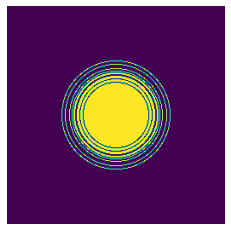

In [8]:
#L1 = 8 optimal path, by overall frequency
r_list_whole = np.array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 54., 45., 37., 41.,
       35., 48., 49., 59., 51., 63., 44., 36., 40., 43., 39.])
np.save('./results_gpr_noniter/r_pattern_L1_8_opt.npy',r_list_whole)
print(r_list_whole.shape)

mask = mask_of_r_order(imgsz-2*w,r_list_whole)
ratio = 0.01


r2 = r_list_whole[:]
r_list = []
for i in range(13):
  del_r = torch.abs(mask[1] - ratio*i)
  r_list.append(torch.argmin(del_r).item())

r_list_new = []  
for i in range(len(r_list)): 
    if i%2 == 0: 
        r_list_new.append(r_list[i])

print(r_list_whole)
print(r_list)
print(r_list_new)
print(len(r_list_new))

#plt.imshow(mask[0])
plt.imshow(mask_larger(imgsz,w,mask[0]))
plt.axis('off')
r_list_new_2 = [0, 19, 28, 34, 39, 43, 49]
for i in r_list_new_2:
    mask = mask_of_r_order(imgsz-2*w,r_list_whole[:i+1])
    print(mask[1][-1])
    


(48,)
[ 1.  0.  2.  8. 13.  3.  6. 18. 11. 23. 16.  5. 28. 10. 21. 34.  4. 15.
 26. 40. 33.  9. 46.  7. 17. 52. 39. 27. 12. 22. 58. 32. 45. 14. 20. 64.
 51. 38. 19. 25. 69. 57. 31. 44. 24. 75. 29. 36.]
[0, 11, 16, 20, 24, 27, 30, 34, 36, 39, 41, 44, 46]
[0, 16, 24, 30, 36, 41, 46]
7
tensor(0.0001)
tensor(0.0194)
tensor(0.0381)
tensor(0.0587)
tensor(0.0802)
tensor(0.1003)
tensor(0.1241)


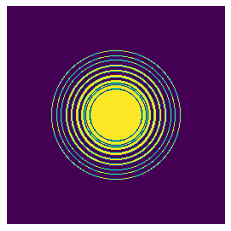

In [6]:
r_list_whole = np.load('./results_gpr_noniter/r_pattern_norRI_opt.npy')

print(r_list_whole.shape)

mask = mask_of_r_order(imgsz-2*w,r_list_whole)
ratio = 0.01


r2 = r_list_whole[:]
r_list = []
for i in range(13):
  del_r = torch.abs(mask[1] - ratio*i)
  r_list.append(torch.argmin(del_r).item())

r_list_new = []  
for i in range(len(r_list)): 
    if i%2 == 0: 
        r_list_new.append(r_list[i])

print(r_list_whole)
print(r_list)
print(r_list_new)
print(len(r_list_new))

plt.imshow(mask_larger(imgsz,w,mask[0]))
plt.axis('off')

r_list_new_2 = [0, 16, 24, 30, 36, 41, 47]
for i in r_list_new_2:
    mask = mask_of_r_order(imgsz-2*w,r_list_whole[:i+1])
    print(mask[1][-1])

In [ ]:
ini = 0
#r_nor_results = torch.zeros(500,7,4)
r_nor_results = torch.from_numpy(np.load('./results_gpr_final/r_nor_L1_8_results_0-250.npy'))
ind = np.linspace(0,(imgsz-2*w)**2-1,(imgsz-2*w)**2,dtype = int)

lamb = 1e-3

bs = 1
train_loader = DataLoader(dataset, batch_size=bs, drop_last=True, shuffle= False,**kwargs)

for j,image in enumerate(train_loader): 
  if j >= 500+ini: 
    img_k0 = image[0,:,:,:]
    for i in range(7): 
     # mask_r,mask_r_ratio = mask_of_r_order(imgsz-2*w,r2[:r_list[i]+1])
        mask_r, ratio_ = mask_of_r_order(imgsz-2*w,r2[:r_list_new_2[i]+1])
        ind_ = ind[mask_r.view(-1) == 1]
        rcon0,nmse_0,ssim_0,psnr_0 = bayesian_mean_samp_nor(img_k0,ind_,lamb)
        r_nor_results[j-500,i,:] = torch.tensor([len(ind_)/imgsz**2,nmse_0,ssim_0,psnr_0])
 #   np.save('./results_gpr_final/r_nor_L1_8_results_0-250.npy',r_nor_results)
        print('round:',i,'k%:',ratio_[-1],nmse_0,ssim_0,psnr_0)
    
    if (j+1) % 1 == 0: 
     # print(r_nor_results[j-500,i,:])
      print('round',j+1,'mean nmse:',torch.mean(r_nor_results[ini:j-499,-1,1]).item(),'mean ssim:',torch.mean(r_nor_results[ini:j-499,-1,2]).item(), \
                                                'mean psnr:',torch.mean(r_nor_results[ini:j-499,-1,3]).item())
    if (j+1) == 500+250: 
        break

round: 0 k%: tensor(0.0001) 0.2023098533576249 0.5001642281030243 21.21621196288505
round: 1 k%: tensor(0.0194) 0.0216915348214714 0.799359494104021 30.913478953219695
round: 2 k%: tensor(0.0381) 0.013150213084409768 0.8741219198475019 33.087053973418506
round: 3 k%: tensor(0.0587) 0.008838619875425153 0.8988466820480793 34.812537311475054
round: 4 k%: tensor(0.0802) 0.006363600437490262 0.923374769104885 36.239352415020726
round: 5 k%: tensor(0.1003) 0.004946510379003913 0.9383159124100946 37.33339304091468
round: 6 k%: tensor(0.1241) 0.0034812524718264852 0.9553171787425617 38.85902658397988
round 501 mean nmse: 0.003481252584606409 mean ssim: 0.9553171992301941 mean psnr: 38.85902786254883
round: 0 k%: tensor(0.0001) 0.18832734113381916 0.37178263374790954 19.318919251951105
round: 1 k%: tensor(0.0194) 0.03689484522336337 0.6436982030174141 26.398398817842622
round: 2 k%: tensor(0.0381) 0.022230926631416948 0.711517838191631 28.598479043455676
round: 3 k%: tensor(0.0587) 0.014800857

In [27]:
ini = 0
r_nor_results = torch.zeros(500,len(r_list_new),4)

ind = np.linspace(0,(imgsz-2*w)**2-1,(imgsz-2*w)**2,dtype = int)

lamb = 1e-3

bs = 1
train_loader = DataLoader(dataset, batch_size=bs, drop_last=True, shuffle= False,**kwargs)

for j,image in enumerate(train_loader): 
  if j >= 500+ini: 
    img_k0 = image[0,:,:,:]
    for i in range(len(r_list_new)): 
     # mask_r,mask_r_ratio = mask_of_r_order(imgsz-2*w,r2[:r_list[i]+1])
        mask_r, ratio_ = mask_of_r_order(imgsz-2*w,r2[:r_list_new[i]+1])
        ind_ = ind[mask_r.view(-1) == 1]
        rcon0,nmse_0,ssim_0,psnr_0 = bayesian_mean_samp_nor(img_k0,ind_,lamb)
        r_nor_results[j-500,i,:] = torch.tensor([len(ind_)/imgsz**2,nmse_0,ssim_0,psnr_0])
 #   np.save('./results_gpr_final/r_nor_delta_results_deltapath_250-500.npy',r_nor_results)
        print('round:',i,'k%:',ratio_[-1],nmse_0,ssim_0,psnr_0)
    
    if (j+1) % 1 == 0: 
     # print(r_nor_results[j-500,i,:])
      print('round',j+1,'mean nmse:',torch.mean(r_nor_results[ini:j-499,-1,1]).item(),'mean ssim:',torch.mean(r_nor_results[ini:j-499,-1,2]).item(), \
                                                'mean psnr:',torch.mean(r_nor_results[ini:j-499,-1,3]).item())
    if (j+1) == 500+1: 
        break

round: 0 k%: tensor(6.1035e-05) 0.21853077928873121 0.4685242094817366 20.88125473237019
round: 1 k%: tensor(0.0052) 0.06325003543423924 0.6600179366082785 26.26577304566638
round: 2 k%: tensor(0.0149) 0.03901197927120981 0.7725423956011618 28.364401460110734
round: 3 k%: tensor(0.0258) 0.022009573406754482 0.8418215820584185 30.85026550914126
round: 4 k%: tensor(0.0347) 0.016910667016506682 0.8817911364263842 31.994773717519823
round: 5 k%: tensor(0.0453) 0.01303177034594357 0.909247328682529 33.12634721107883
round: 6 k%: tensor(0.0554) 0.01047784100668004 0.9303901670001871 34.07366432209046
round: 7 k%: tensor(0.0656) 0.00895010900123333 0.9441380942829068 34.75809762371064
round: 8 k%: tensor(0.0736) 0.008104672124345605 0.9486858987589789 35.189027323063534
round: 9 k%: tensor(0.0841) 0.007627293353013625 0.9591371673376885 35.45267716812846
round: 10 k%: tensor(0.0934) 0.006673522789531874 0.9588042447660231 36.03283003792063
round: 11 k%: tensor(0.1060) 0.0054587762210237725 0.

In [28]:
r_nor_single_10 = r_nor_results[0,:,:]
np.save('./results_gpr_hyper/envelop_10e-3.npy',r_nor_single_10)

In [29]:
r_nor_single_1 = np.load('./results_gpr_hyper/envelop_1e-3.npy')
r_nor_single_5 = np.load('./results_gpr_hyper/envelop_5e-3.npy')
r_nor_single_10 = np.load('./results_gpr_hyper/envelop_10e-3.npy')
r_nor_single_16 = np.load('./results_gpr_hyper/envelop_16e-3.npy')
r_nor = (np.load('./results_gpr_final/r_nor_results_4.npy'))[0,:,:]

In [31]:
r_nor_single_1

array([[1.22070312e-04, 5.02703130e-01, 3.28898937e-01, 1.72632656e+01],
       [5.43212891e-03, 7.16001391e-02, 5.01533568e-01, 2.57272434e+01],
       [1.51977539e-02, 3.52171399e-02, 7.00792432e-01, 2.88088417e+01],
       [2.40478516e-02, 2.32469384e-02, 8.06712925e-01, 3.06127243e+01],
       [3.56445312e-02, 1.59720220e-02, 8.73878837e-01, 3.22427826e+01],
       [4.63256836e-02, 1.21142240e-02, 9.09557939e-01, 3.34434280e+01],
       [5.59692383e-02, 1.00118108e-02, 9.25847232e-01, 3.42712555e+01],
       [6.74438477e-02, 8.61710031e-03, 9.37995017e-01, 3.49227715e+01],
       [7.35473633e-02, 8.21975991e-03, 9.44254041e-01, 3.51277924e+01],
       [8.29467773e-02, 6.85193343e-03, 9.46595252e-01, 3.59182510e+01],
       [9.64355469e-02, 5.28069306e-03, 9.54571486e-01, 3.70494728e+01],
       [1.03515625e-01, 5.09136217e-03, 9.58893597e-01, 3.72080421e+01],
       [1.14318848e-01, 4.20517614e-03, 9.62487638e-01, 3.80385399e+01],
       [1.24084473e-01, 3.93705908e-03, 9.65889513e

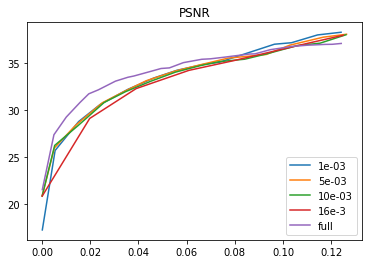

In [40]:
title = ['NMSE','SSIM','PSNR']

i= 3

plt.plot(r_nor_single_1[:,0],r_nor_single_1[:,i],label = '1e-03')
plt.plot(r_nor_single_5[:,0],r_nor_single_5[:,i],label = '5e-03')
plt.plot(r_nor_single_10[:,0],r_nor_single_10[:,i],label = '10e-03')
plt.plot(r_nor_single_16[:,0],r_nor_single_16[:,i],label = '16e-3')
plt.plot(r_nor[:,0],r_nor[:,i],label = 'full')
plt.title(title[i-1])
if i == 1: 
    
    plt.yscale('log')
plt.legend()

plt.savefig('hyper_PSNR_singleimg.pdf')

## Detailed Tuning ##

In [9]:
r_list_whole_nor = np.load('./results_gpr_noniter/r_pattern_norRI_opt.npy')

r_list_whole_16 = np.array([ 0.,  1.,  2.,  4.,  8.,  6., 11.,  3.,  7., 13., 10., 15.,  5., 18.,
         9., 14., 20., 17., 23., 12., 25., 21., 29., 16., 27., 33., 19., 24.,
        31., 37., 28., 35., 41., 22., 32., 45., 39., 26., 36., 49., 43., 30.,
        53., 40., 47., 57., 34., 51., 44., 61.])

r_list_whole_L1 = np.load('./results_gpr_noniter/r_pattern_L1_8_opt.npy')

### L1 Tuning ###

In [9]:
#Make Temporary Covariance Matrix 

dis = torch.load('./brain_stats/dis.pt')
L1_list = np.linspace(5,30,26,dtype = int)
#L1_list = np.linspace(2,10,9,dtype = int)
for ii in range(len(L1_list)): 
    realcov = torch.load('./brain_stats/real_cov_6822_nor.pt')
    imagcov = torch.load('./brain_stats/imag_cov_6822_nor.pt')
    
    a = L1_list[ii]
    ind0 = torch.linspace(0,(imgsz-2*w)**2-1,(imgsz-2*w)**2,dtype = int).view(-1,1)
    for i in range(len(ind0)):
        ind = ind0[i]
      #  x_,y_ = ind_to_xy(ind)
        
        d = dis[int(ind),:]
        

        realcov[ind,:] = realcov[ind,:] * (np.exp(-(0.5*d**2/a**2)))
        imagcov[ind,:] = imagcov[ind,:] * (np.exp(-(0.5*d**2/a**2)))

    torch.save(realcov,'./results_gpr_hyper_new/covmat_6822/realcov_L1_'+str(a)+'.pt')
    torch.save(imagcov,'./results_gpr_hyper_new/covmat_6822/imagcov_L1_'+str(a)+'.pt')  
    print('L1 = ',a, 'loading done')      

L1 =  5 loading done
L1 =  6 loading done
L1 =  7 loading done
L1 =  8 loading done
L1 =  9 loading done
L1 =  10 loading done
L1 =  11 loading done
L1 =  12 loading done
L1 =  13 loading done
L1 =  14 loading done
L1 =  15 loading done
L1 =  16 loading done
L1 =  17 loading done
L1 =  18 loading done
L1 =  19 loading done
L1 =  20 loading done
L1 =  21 loading done
L1 =  22 loading done
L1 =  23 loading done
L1 =  24 loading done
L1 =  25 loading done
L1 =  26 loading done
L1 =  27 loading done
L1 =  28 loading done
L1 =  29 loading done
L1 =  30 loading done


In [5]:
#L1 1st round tuning 25 random sample index
samp_ind = [552,555,556,562,573,578,588,603,625,637,655,662,675,738,739,746,769,792,823,856,876,890,932,955,999]
print(len(samp_ind))

25


In [28]:
#L1 testing 25 random sample index 
samp_ind = [461, 486, 489, 485, 476, 431, 458, 438, 466, 488, 453, 495, 449, 451, 481, 496, 444, 447, 484, 457, 459, 474, 464, 433, 450]


In [ ]:
#total hyper 20, random sample 10
r_list_whole_nor = np.load('./results_gpr_noniter_new/rnor_pattern_6822_opt.npy')

realmean = torch.load('./brain_stats/train_realmean_6822.pt')
imagmean = torch.load('./brain_stats/train_imagmean_6822.pt')

magmean = torch.load('./brain_stats/train_magmean_6822.pt')

realmean = realmean/magmean
imagmean = imagmean/magmean

realvar= torch.diagonal(realcov)
imagvar= torch.diagonal(imagcov)


ind0 = np.linspace(0,(imgsz-2*w)**2-1,(imgsz-2*w)**2,dtype = int)


L1_list = [5,6,7,8,9,10]
#L1_list = np.linspace(7,15,9,dtype = int)
#print(L1_list)

lamb = 1e-3
bs = 1
train_loader = DataLoader(dataset, batch_size=bs, drop_last=False, shuffle= False,**kwargs)

r_nor_results = torch.zeros(len(L1_list),4)

#samp_ind = random.sample(range(500, 1000), 25) 

for ii in range(len(L1_list)):

    
    a = L1_list[ii]
    realcov = torch.load('./results_gpr_hyper_new/covmat/realcov_L1_'+str(a)+'.pt')
    imagcov = torch.load('./results_gpr_hyper_new/covmat/imagcov_L1_'+str(a)+'.pt')
        
  #  print(len(samp_ind))
    
    for j,image in enumerate(train_loader): 
        if j in samp_ind: 
       #         print(j)
      #      print('yes')
            img_k0 = image[0,:,:,:]
            mask_r, ratio_ = mask_of_r_order(imgsz-2*w,r_list_whole_nor)
            ind_ = ind0[mask_r.view(-1) == 1]
            rcon0,nmse_0,ssim_0,psnr_0 = bayesian_mean_samp_nor(img_k0,ind_,lamb)
            print(j,nmse_0,ssim_0,psnr_0)
            r_nor_results[ii,:] += torch.tensor([a,nmse_0,ssim_0,psnr_0])/25

        np.save('./results_gpr_hyper_new/L1_testing_round2_5-10.npy',r_nor_results)
        
    print('avg',r_nor_results[ii,:])
    print('----------------------')
                      

431 0.0034233337030014637 0.9379778505418768 34.93128990755159
433 0.0022956979452669205 0.944929137255436 36.54340958783504
438 0.0027291778666077835 0.9794819877150394 39.93619957049625
444 0.0028042106517699706 0.9263824409134842 35.45322095493918
447 0.005714189788452562 0.9202875546526164 34.022051111947775
449 0.0033349968368161895 0.9352357941016641 35.089704244542304
450 0.0034860595656663732 0.9373478721848771 35.56558820789528
451 0.004814881950645461 0.8919359694088806 34.631544979149645
453 0.0031886202415365903 0.9215867773195385 33.619758075027704
457 0.0035998401002009244 0.9224868794568125 34.69107762587966
458 0.004037071100479436 0.9335343108013032 35.54025725812461
459 0.003181684204017509 0.9388561910847659 35.121632425443934
461 0.004171314002627683 0.9396630349890992 38.020872263600744
464 0.0033694956778188754 0.9727617210986218 39.33864837582927
466 0.005323875870909069 0.9114956811098361 33.52660352741744
474 0.0034417851065192454 0.943019492804314 33.096961373

In [8]:
r_nor_results1 = (np.load('./results_gpr_hyper_new/L1_testing_round2_5-10.npy'))
r_nor_results2 =  (np.load('./results_gpr_hyper_new/L1_testing_round2_11-16.npy'))
r_nor_results = np.concatenate((r_nor_results1,r_nor_results2),axis = 0)
np.save('./results_gpr_hyper_new/L1_testing_round2_6822_5-16.npy',r_nor_results)

In [9]:
a = np.load('./results_gpr_hyper_new/L1_testing_round1_6822_1-30.npy')
a

array([[1.0000002e+00, 7.3127733e-03, 7.7034152e-01, 3.2624165e+01],
       [2.0000005e+00, 5.1465188e-03, 8.4734720e-01, 3.4177200e+01],
       [2.9999990e+00, 4.4075642e-03, 8.8107431e-01, 3.4869564e+01],
       [4.0000010e+00, 4.0936274e-03, 8.9717174e-01, 3.5194756e+01],
       [4.9999995e+00, 3.9383648e-03, 9.0591711e-01, 3.5362980e+01],
       [5.9999981e+00, 3.8536831e-03, 9.1105282e-01, 3.5457100e+01],
       [7.0000019e+00, 3.8047633e-03, 9.1422868e-01, 3.5512543e+01],
       [8.0000019e+00, 3.7758378e-03, 9.1624916e-01, 3.5545990e+01],
       [9.0000000e+00, 3.7589502e-03, 9.1755241e-01, 3.5566036e+01],
       [9.9999990e+00, 3.7497305e-03, 9.1838825e-01, 3.5577461e+01],
       [1.0999998e+01, 3.7456369e-03, 9.1890496e-01, 3.5583057e+01],
       [1.1999996e+01, 3.7451230e-03, 9.1919541e-01, 3.5584553e+01],
       [1.3000004e+01, 3.7472299e-03, 9.1931903e-01, 3.5583050e+01],
       [1.4000004e+01, 3.7513401e-03, 9.1931653e-01, 3.5579247e+01],
       [1.5000004e+01, 3.7570172e-

[  0.  13.  27.  40.  54.  67.  81.  94. 108. 121. 134. 148. 162. 175.
 189. 202. 216. 229. 243. 256.]


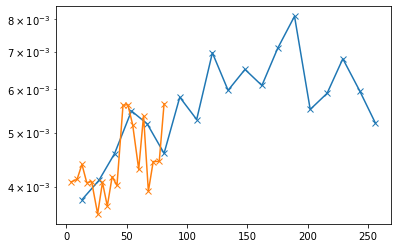

In [21]:
r_nor_results1 = (np.load('./results_gpr_hyper/round1_0-256.npy'))
r_nor_results2 = (np.load('./results_gpr_hyper/round2_0-81.npy'))

plt.plot(r_nor_results1[:,0],r_nor_results1[:,1],'-x')
plt.plot(r_nor_results2[:,0],r_nor_results2[:,1],'-x')
plt.yscale('log')
print(r_nor_results1[:,0])

In [7]:
r_nor_results2 = (np.load('./results_gpr_hyper/round2_2-10.npy'))
print(r_nor_results2)

[[2.0000000e+00 5.2198344e-03 8.4274262e-01 3.3802792e+01]
 [3.0000000e+00 4.3210611e-03 8.7943733e-01 3.4673824e+01]
 [4.0000000e+00 3.9943387e-03 8.9581358e-01 3.5043026e+01]
 [5.0000000e+00 3.8492833e-03 8.6328191e-01 3.3770432e+01]
 [5.9999981e+00 3.7027961e-03 9.1381150e-01 3.5414574e+01]
 [7.0000019e+00 3.6887617e-03 9.1496170e-01 3.5436653e+01]
 [8.0000019e+00 3.6817014e-03 9.1567856e-01 3.5449867e+01]
 [9.0000000e+00 4.6116561e-03 8.8827103e-01 3.4659496e+01]
 [9.9999990e+00 4.1343947e-03 9.0188390e-01 3.5066093e+01]]


[ 1.0000002  5.999998  10.999998  16.000004  21.999996  28.000008
 34.000004 ]


Text(0.5, 0, 'L1')

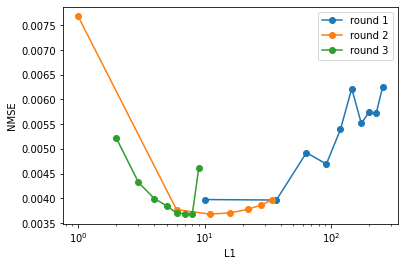

In [35]:
r_nor_results1 = (np.load('./results_gpr_hyper/round1_1-34.npy'))
r_nor_results2 = (np.load('./results_gpr_hyper/round2_2-10.npy'))[:-1,:]
r_nor_results3 = (np.load('./results_gpr_hyper/round1_10-256.npy'))
r_nor_results = np.concatenate((r_nor_results3,r_nor_results1,r_nor_results2),axis= 0)
r_nor_results = r_nor_results[np.argsort(r_nor_results[:,0])]
#print(r_nor_results1)
#print(r_nor_results2)
#print(r_nor_results3)

plt.plot(r_nor_results3[:,0],r_nor_results3[:,1],'-o',label = 'round 1')
plt.plot(r_nor_results1[:,0],r_nor_results1[:,1],'-o',label = 'round 2')
plt.plot(r_nor_results2[:,0],r_nor_results2[:,1],'-o',label = 'round 3')

#plt.plot(r_nor_results3[:,0],r_nor_results3[:,1],'-x')
plt.xscale('log')
#plt.xlim(0,15)
#plt.yscale('log')
print(r_nor_results1[:,0])
plt.legend()
plt.ylabel('NMSE')
plt.xlabel('L1')

Text(0.5, 0, 'L1')

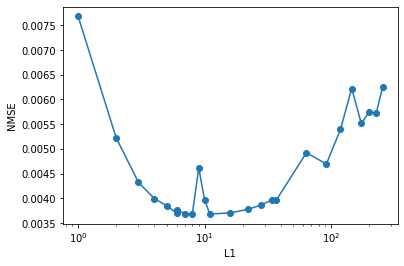

In [36]:
#r_nor_results = np.sort(r_nor_results,axis = 0)
plt.xscale('log')
plt.plot(r_nor_results[:,0],r_nor_results[:,1],'-o')
plt.ylabel('NMSE')
plt.xlabel('L1')

* L1 Tuning Results

In [31]:
a = np.load('./results_gpr_final/r_nor_delta_results_deltapath.npy')
a[499,:]

array([[6.10351562e-05, 1.29636511e-01, 2.94081986e-01, 1.84227047e+01],
       [1.92871094e-02, 2.41644103e-02, 6.57898366e-01, 2.57182159e+01],
       [4.03442383e-02, 1.49523551e-02, 7.92317450e-01, 2.78028831e+01],
       [5.87768555e-02, 1.14289830e-02, 8.18209946e-01, 2.89699020e+01],
       [8.06274414e-02, 8.27564951e-03, 8.48328114e-01, 3.03719578e+01],
       [1.01745605e-01, 6.18984737e-03, 8.75337958e-01, 3.16331787e+01],
       [1.19934082e-01, 4.89568245e-03, 8.97598624e-01, 3.26518440e+01],
       [1.24877930e-01, 4.61455900e-03, 9.04360414e-01, 3.29086761e+01]],
      dtype=float32)

In [4]:
results_nor = np.load('./results_gpr_final/r_nor_results.npy')
results_nor = np.mean(results_nor, axis = 0)

[[6.10351562e-05 1.63349882e-01 4.12211239e-01 1.88795605e+01]
 [1.92871094e-02 3.38719450e-02 7.28160143e-01 2.57751408e+01]
 [4.03442383e-02 1.88620761e-02 8.42331231e-01 2.83389301e+01]
 [5.87768555e-02 1.30750351e-02 8.87006640e-01 2.99107971e+01]
 [7.90405273e-02 7.33451266e-03 8.99088860e-01 3.23850632e+01]
 [9.85717773e-02 5.34259435e-03 9.11453485e-01 3.37532997e+01]
 [1.24572754e-01 3.68578034e-03 9.37848985e-01 3.53324623e+01]]


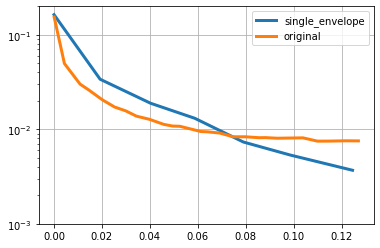

In [22]:
results_L1_8_1 = np.load('./results_gpr_final/r_nor_L1_8_results_0-250.npy')[:250,:,:]
results_L1_8_2 = np.load('./results_gpr_final/r_nor_delta_results_deltapath_250-500.npy')[250:,:,:]
results_L1_8 = np.mean(np.concatenate((results_L1_8_1,results_L1_8_2),axis = 0), axis = 0)
#np.mean(np.concatenate((results_L1_8_1,results_L1_8_2),axis = 0), axis = 0)
plt.plot(results_L1_8[:,0],results_L1_8[:,1],linewidth = 3,label = 'single_envelope')
plt.plot(results_nor[:,0],results_nor[:,1],linewidth = 3,label = 'original')
plt.yscale('log')
plt.ylim(1e-3,2e-1)
plt.legend()
plt.grid('on')
print(results_L1_8)

In [ ]:
with 12.49% total k-space information: NMSE: 0.0037     SSIM: 0.937   PSNR: 35.24

## L2 Tuning ##

**first round: 1-256** \
np.linspace(1,256,10,dtype = int)

**second round: 2-141** \
np.linspace(2,141,10,dtype = int)


In [3]:
def true_her(x,y): 
    return 1-x, -1-y

In [5]:
#Make Temporary Covariance Matrix 

dis = torch.load('./brain_stats/dis.pt')

#L2_list = np.linspace(5,20,16,dtype = int)
L2_list = [12,14,16,18]
for ii in range(len(L2_list)): 
    realcov = torch.load('./brain_stats/real_cov_431_nor.pt')
    imagcov = torch.load('./brain_stats/imag_cov_431_nor.pt')


    b = L2_list[ii]
    ind0 = torch.linspace(0,(imgsz-2*w)**2-1,(imgsz-2*w)**2,dtype = int).view(-1,1)
    for i in range(len(ind0)):
        ind = ind0[i]
        x_,y_ = ind_to_xy(ind)
        x_her,y_her = true_her(x_,y_)
        ind_her = xy_to_ind(x_her,y_her)

        if ind_her+1 >= 160**2: 
            ind_her = xy_to_ind(-x_,-y_)       
        d = dis[int(ind),:]
        d_her = dis[int(ind_her),:]

        realcov[ind,:] = realcov[ind,:] * ((np.exp(-(0.5*d**2/b**2))+np.exp(-(0.5*d_her**2/b**2)))/(1+np.exp(-(0.5*d**2/b**2+0.5*d_her**2/b**2))))
        imagcov[ind,:] = imagcov[ind,:] * ((np.exp(-(0.5*d**2/b**2))+np.exp(-(0.5*d_her**2/b**2)))/(1+np.exp(-(0.5*d**2/b**2+0.5*d_her**2/b**2))))
  

    torch.save(realcov,'./results_gpr_hyper_new/covmat_431/realcov_L1_'+str(b)+'_L2_'+str(b)+'.pt')
    torch.save(imagcov,'./results_gpr_hyper_new/covmat_431/imagcov_L1_'+str(b)+'_L2_'+str(b)+'.pt')
    print('L2 = ',b, 'loading done')      

<ipython-input-2-4bde8d9c015f>:355: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  i = (ind//(imgsz-2*w))


L2 =  12 loading done
L2 =  14 loading done
L2 =  16 loading done
L2 =  18 loading done


In [17]:
np.random.permutation(np.linspace(431,499,69,dtype = int))[:25]

array([449, 485, 497, 482, 483, 463, 476, 461, 451, 489, 447, 454, 437,
       452, 432, 457, 471, 473, 488, 478, 450, 442, 456, 439, 458])

In [21]:
#6822 round1 
samp_ind = np.array([451, 446, 469, 476, 487, 439, 465, 438, 432, 494, 499, 436, 444,
       486, 441, 459, 497, 485, 434, 449, 461, 466, 450, 496, 474])

In [13]:
#6822 round2
samp_ind = np.array([449, 457, 475, 452, 468, 490, 481, 445, 456, 439, 482, 474, 462,
       476, 437, 495, 453, 450, 480, 471, 483, 497, 433, 470, 465])

In [ ]:
avg tensor([6.0000e+00, 2.5898e-03, 9.4800e-01, 3.6802e+01])

In [23]:
#total hyper 15, random sample 25
r_list_whole_nor = np.load('./results_gpr_noniter_new/rnor_pattern_L1L2_11_6822_opt.npy')[:44]



ind0 = np.linspace(0,(imgsz-2*w)**2-1,(imgsz-2*w)**2,dtype = int)


L2_list = np.linspace(7,15,9,dtype = int)
#print(L1_list)

lamb = 1e-3
bs = 1
train_loader = DataLoader(dataset, batch_size=bs, drop_last=True, shuffle= False,**kwargs)

r_nor_results = torch.zeros(len(L2_list),4)

#samp_ind = random.sample(range(500, 1000), 25) 

for ii in range(len(L2_list)):
    
    a = L2_list[ii]

    realcov = torch.load('./results_gpr_hyper_new/covmat_6822/realcov_L1_'+str(a)+'_L2_'+str(a)+'.pt')
    imagcov = torch.load('./results_gpr_hyper_new/covmat_6822/imagcov_L1_'+str(a)+'_L2_'+str(a)+'.pt')
        

    
    for j,image in enumerate(train_loader): 
        if j in samp_ind: 
 
            img_k0 = image[0,:,:,:]
            mask_r, ratio_ = mask_of_r_order(imgsz-2*w,r_list_whole_nor)
            ind_ = ind0[mask_r.view(-1) == 1]
            rcon0,nmse_0,ssim_0,psnr_0 = bayesian_mean_samp_nor(img_k0,ind_,lamb)
            print(j,nmse_0,ssim_0,psnr_0)
            r_nor_results[ii,:] += torch.tensor([a,nmse_0,ssim_0,psnr_0])/25

            np.save('./results_gpr_hyper_new/L1L2_testing_round2_6822_7-15.npy',r_nor_results)
        
    print('avg',r_nor_results[ii,:])
    print('----------------------')

432 0.0017142104662362827 0.9522233708924407 35.72814915729656
434 0.00334248661130613 0.9403802796196336 37.9268556436441
436 0.0018140421376988418 0.9615508902340739 36.95422752435323
438 0.001779879883556576 0.9847013104244301 41.79261167025576
439 0.0026727333953468118 0.9350830187631366 36.59539511367653
441 0.0032386852335036208 0.9548447855902702 35.26370015402398
444 0.001741306646726315 0.9514381376840474 37.52257503533925
446 0.0021332586223463987 0.9564620338728445 37.205174814272276
449 0.0021936394828250523 0.9561887379297906 36.90900488907648
450 0.002168314518621998 0.9588571447586702 37.627713274282904
451 0.0028208454791319557 0.9334198148648366 36.95360793892428
459 0.0019178802127920959 0.9600977009136384 37.31998899470493
461 0.002743160744934907 0.959215794781083 39.84108876529782
465 0.0029401981311223432 0.9170533736932838 37.318363732752566
466 0.003445561685007127 0.938834121300008 35.416281979782184
469 0.0027648186761486744 0.9399886808590033 34.9859258582934

432 0.0017370253886178433 0.9532032154119392 35.67072863557418
434 0.0032720110515185833 0.9437327450644192 38.0194049863852
436 0.001772069006765163 0.9655085075827798 37.05589497580149
438 0.0017800526772205755 0.9844828977417416 41.79218979750162
439 0.0028224061443911526 0.9307738457297866 36.358756300241104
441 0.003148747941843641 0.9588465310631171 35.38600799857982
444 0.001724953381964476 0.9528380788708547 37.56355455504163
446 0.0020860286940726767 0.9594011429350688 37.30240637261352
449 0.0021536729590705276 0.9589169692249597 36.988860500942074
450 0.002085077028609768 0.9634623710035903 37.79771519544228
451 0.0027996568633067947 0.9348029293367467 36.9863527974934
459 0.0018707780626772148 0.9637257082147896 37.42798025136544
461 0.0026501634116605876 0.9628610194705345 39.990874650778004
465 0.002931014535572599 0.9172734477514751 37.33195038586746
466 0.003454608044153888 0.9410662553272956 35.40489450159043
469 0.0027152819774507206 0.9437497955490787 35.064443627527